# DQN (train)
https://simoninithomas.github.io/Deep_reinforcement_learning_Course/  
https://medium.freecodecamp.org/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8  
https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682  
https://github.com/yandexdataschool/Practical_RL/blob/master/week4_approx_rl/homework_pytorch.ipynb  
http://maciejjaskowski.github.io/2016/03/09/space-invaders.html  
https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf

## 1. Setup

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import gym
import sys
import tensorflow as tf

from collections import deque
from dqn import DQN
from params import *
from preprocessing import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f'sys.version: {sys.version}')
print(f'skimage.version: {skimage.__version__}')
print(f'tf.version: {tf.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
skimage.version: 0.14.1
tf.version: 1.11.0


## 2. Look at the Breakout-v0 env

In [2]:
env = gym.make('Breakout-v0')
env.reset()
env.render()
print(f'action_space.size: {env.action_space.n}')

action_space.size: 4


In [3]:
print(f'Num_Actions: {env.action_space.n}')
action_meanings = env.unwrapped.get_action_meanings()
for i in range(env.action_space.n):
    print(f'{i}: {action_meanings[i]}')

Num_Actions: 4
0: NOOP
1: FIRE
2: RIGHT
3: LEFT


__Look how the rgb frame is preprocessed__

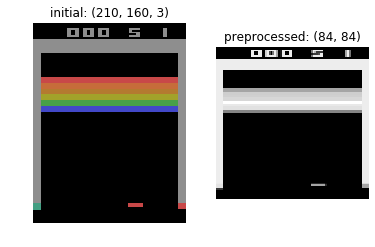

In [4]:
rgb_frame = env.reset()
preprocessed_frame = preprocess_frame(rgb_frame)

plt.figure()

plt.subplot(1, 2, 1)
plt.title(f'initial: {rgb_frame.shape}')
plt.axis('off')
plt.imshow(rgb_frame)

plt.subplot(1, 2, 2)
plt.title(f'preprocessed: {preprocessed_frame.shape}')
plt.axis('off')
plt.imshow(preprocessed_frame, cmap='gray')

plt.show()

## 3. DQN

### CNN architecture
1. Conv2d(filters=32, kernel_size=8, strides=4, padding='valid', activation=ReLU)
2. Conv2d(filters=64, kernel_size=4, strides=2, padding='valid', activation=ReLU)  
2. Conv2d(filters=64, kernel_size=3, strides=1, padding='valid', activation=ReLU) -> Flatten()  
3. FC(512, activation=ReLU)
4. FC(NUM_ACTIONS, activation=Linear)

### Instantiate DQNs: DQN and TargetDQN

In [5]:
tf.reset_default_graph()

dqn = DQN(state_shape=STATE_SHAPE, action_size=ACTION_SIZE, dqn_name='DQN')
dqn_target = DQN(state_shape=STATE_SHAPE, action_size=ACTION_SIZE, dqn_name='DQNTarget')

## 4. Training

### Memory class (for Experience Replay)

In [6]:
class Memory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        indices = np.random.choice(np.arange(buffer_size),
                                   size=batch_size,
                                   replace=False)
        experiences_batch = [self.buffer[idx] for idx in indices]
        return experiences_batch

#### Pre-populate memory by taking random actions and storing each experience (state, action, reward, next_state, done)

In [7]:
def get_pre_populated_memory(env):
    memory = Memory(max_size=MEMORY_SIZE)
    stacked_frames = []
    state = None

    for step in range(PRETRAIN_LENGTH):
        if step == 0:
            state = env.reset()
            state, stacked_frames = stack_frames(stacked_frames, state,
                                                 is_new_episode=True)

        # random action
        action_idx = np.random.randint(ACTION_SIZE)
        action = POSSIBLE_ACTIONS[action_idx]
        
        # next state
        next_state, reward, done, _ = env.step(action)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                  is_new_episode=False)

        if done:
            # the end of episode (next_state = 0)
            next_state = np.zeros(STATE_SHAPE)
            next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                      is_new_episode=False)

            # add experience to memory
            memory.add((state, action_idx, reward, next_state, done))

            # start a new episode
            state = env.reset()
            state, stacked_frames = stack_frames(stacked_frames, state,
                                                 is_new_episode=True)
        else:
            # add experience to memory
            memory.add((state, action_idx, reward, next_state, done))
            state = next_state
    
    return memory

### Helper function to copy DQN parameters to DQNTarget

In [8]:
def update_dqn_target():
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DQN')
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DQNTarget')
    
    op_holder = []
    for from_var, to_var in zip(from_vars, to_vars):
        op_holder.append(to_var.assign(from_var))
        
    return op_holder

### DQN (training algorithm)

In [9]:
def eps_greedy(sess, state, eps_decay_step):
    # eps: exploration probability
    eps = EPS_END + (EPS_START - EPS_END) * np.exp(-EPS_DECAY_RATE * eps_decay_step)
    
    if np.random.rand() < eps:
        # exploration with eps probability
        action_idx = np.random.randint(ACTION_SIZE)
    else:
        # exploitation with (1 - eps) probability
        Q = sess.run(dqn.output,
                     feed_dict={
                         dqn.input_ph: state.reshape(1, *STATE_SHAPE)
                     })
        
        action_idx = np.argmax(Q)

    return action_idx, eps

In [10]:
def dqn_training(dqn, dqn_target,
                 num_episodes=NUM_EPISODES, 
                 max_steps_per_episode=MAX_STEPS_PER_EPISODE, 
                 batch_size=BATCH_SIZE,
                 learning_rate=LEARNING_RATE):
    
    # memory for experience replay
    memory = get_pre_populated_memory(env)
    
    # update dqn target op
    update_dqn_target_op = update_dqn_target()    
    
    # to save some ckpts
    saver = tf.train.Saver(max_to_keep=30)
    
    with tf.Session() as sess:
        # init tf variables
        sess.run(tf.global_variables_initializer())
        
        # init dqn_target with the same params as dqn
        sess.run(update_dqn_target_op)
        
        step = 0
        best_rewards = [0 for _ in range(2)]
        best_episodes = [[] for _ in range(2)]
        iters_per_episode = []
        reward_per_episode = []
        loss_per_iter = []
        
        for episode in range(1, num_episodes + 1):
            episode_step = 0
            done = False
            stacked_frames = []
            episode_rewards = []
            episode_states = []
            
            # new episode
            state = env.reset()
            episode_states.append(state.copy())
            state, stacked_frames = stack_frames(stacked_frames, state,
                                                 is_new_episode=True)
            
            
            while (not done) and (episode_step < max_steps_per_episode):
                episode_step += 1
                step += 1
                
                action_idx, eps = eps_greedy(sess, state, step)
                action = POSSIBLE_ACTIONS[action_idx]
                next_state, reward, done, _ = env.step(action)
                episode_rewards.append(reward)
                episode_states.append(next_state)
                
                if done:
                    # the end of episode (next_state = 0)
                    next_state = np.zeros(STATE_SHAPE)
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)
                    # add experience to memory
                    memory.add((state, action_idx, reward, next_state, done))
                    
                    total_reward = np.sum(episode_rewards)
                    reward_per_episode.append(total_reward)
                    iters_per_episode.append(episode_step)
                    
                    print(f'Episode: {episode}, '
                          f'Total reward: {total_reward}, '
                          f'Epsilon: {eps}')
                else:
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)
                    # add experience to memory
                    memory.add((state, action_idx, reward, next_state, done))
                    
                    state = next_state
                    
                ### learning part ###
                # sample a random batch of experiences from memory
                batch = memory.sample(batch_size)
                batch_states = np.array([experience[0] for experience in batch], ndmin=3)
                batch_action_indices = np.array([experience[1] for experience in batch])
                batch_rewards = np.array([experience[2] for experience in batch])
                batch_next_states = np.array([experience[3] for experience in batch], ndmin=3)
                batch_dones = np.array([experience[4] for experience in batch])

                # if the episode ends at next_state:
                #     Q_target(state) = reward
                # else:
                #     Q_target(state) = reward + gamma * argmax(a){Q_next_state}
                Q_batch_next_state = sess.run(dqn_target.output,
                                              feed_dict={
                                                  dqn_target.input_ph: batch_next_states
                                              })
                
                # terminal states => Q value = 0
                Q_batch_next_state[batch_dones, :] = 0
                
                Q_target = batch_rewards + GAMMA * np.max(Q_batch_next_state, axis=1)
                
                loss, _ = sess.run([dqn.loss, dqn.optimization_step],
                                   feed_dict={
                                       dqn.input_ph: batch_states,
                                       dqn.action_indices_ph: batch_action_indices,
                                       dqn.Q_target_ph: Q_target,
                                       dqn.learning_rate_ph: learning_rate
                                   })
                
                if step % Q_TARGET_UPDATE_FREQ == 0:
                    print('Update parameters of DQNTarget')
                    sess.run(update_dqn_target_op)
                
                loss_per_iter.append(loss)
            
            # keep 2 train episodes with high reward
            min_pos = np.argmin(best_rewards)
            max_pos = np.argmax(best_rewards)
            min_reward = best_rewards[min_pos]
            max_reward = best_rewards[max_pos]
            cur_reward = reward_per_episode[-1]
            
            if cur_reward > max_reward:
                best_episodes[min_pos] = best_episodes[max_pos]
                best_rewards[min_pos] = best_rewards[max_pos]
                best_episodes[max_pos] = [episode, cur_reward, episode_states]
                best_rewards[max_pos] = cur_reward
            elif cur_reward > min_reward:
                best_episodes[min_pos] = [episode, cur_reward, episode_states]
                best_rewards[min_pos] = cur_reward
            
            if (episode == 1) or (episode % SAVE_EVERY == 0):
                saver.save(sess, f'{SAVE_PATH}/model_episode_{episode}.ckpt')
                print('Model saved')
                
    return iters_per_episode, reward_per_episode, loss_per_iter, best_episodes

In [11]:
%%time
!rm -rf $SAVE_PATH
train_stats = dqn_training(dqn, dqn_target, num_episodes=NUM_EPISODES)

Episode: 1, Total reward: 0.0, Epsilon: 0.9836042852663285
Model saved
Episode: 2, Total reward: 3.0, Epsilon: 0.9516229632511101
Episode: 3, Total reward: 2.0, Epsilon: 0.9269976807927134
Update parameters of DQNTarget
Episode: 4, Total reward: 2.0, Epsilon: 0.9017670494328143
Episode: 5, Total reward: 4.0, Epsilon: 0.864746508019368
Episode: 6, Total reward: 5.0, Epsilon: 0.8252582572681852
Update parameters of DQNTarget
Episode: 7, Total reward: 0.0, Epsilon: 0.8099145769295795
Episode: 8, Total reward: 3.0, Epsilon: 0.7832519575339206
Episode: 9, Total reward: 0.0, Epsilon: 0.7693060644845617
Episode: 10, Total reward: 1.0, Epsilon: 0.7535268982558839
Update parameters of DQNTarget
Episode: 11, Total reward: 1.0, Epsilon: 0.7350966404389971
Episode: 12, Total reward: 2.0, Epsilon: 0.7124715787742542
Episode: 13, Total reward: 4.0, Epsilon: 0.6830401210705365
Update parameters of DQNTarget
Episode: 14, Total reward: 1.0, Epsilon: 0.6668166730733279
Episode: 15, Total reward: 2.0, Ep

Episode: 118, Total reward: 2.0, Epsilon: 0.03468028984587894
Update parameters of DQNTarget
Episode: 119, Total reward: 2.0, Epsilon: 0.033936510831683
Episode: 120, Total reward: 4.0, Epsilon: 0.032757731711930325
Update parameters of DQNTarget
Episode: 121, Total reward: 0.0, Epsilon: 0.03208734771787675
Episode: 122, Total reward: 1.0, Epsilon: 0.03152263007331482
Episode: 123, Total reward: 0.0, Epsilon: 0.03100173268498642
Episode: 124, Total reward: 0.0, Epsilon: 0.030460678927365703
Update parameters of DQNTarget
Episode: 125, Total reward: 2.0, Epsilon: 0.029495914740390948
Episode: 126, Total reward: 1.0, Epsilon: 0.028887587176019858
Episode: 127, Total reward: 0.0, Epsilon: 0.028480293407720195
Update parameters of DQNTarget
Episode: 128, Total reward: 2.0, Epsilon: 0.027907237184692534
Episode: 129, Total reward: 4.0, Epsilon: 0.027067992793941113
Episode: 130, Total reward: 0.0, Epsilon: 0.026663237458975676
Update parameters of DQNTarget
Episode: 131, Total reward: 4.0, 

Update parameters of DQNTarget
Episode: 230, Total reward: 3.0, Epsilon: 0.010486803339944992
Episode: 231, Total reward: 2.0, Epsilon: 0.010473172597784533
Episode: 232, Total reward: 4.0, Epsilon: 0.010452940251712953
Update parameters of DQNTarget
Episode: 233, Total reward: 1.0, Epsilon: 0.010435920645962398
Episode: 234, Total reward: 0.0, Epsilon: 0.01042388416498232
Episode: 235, Total reward: 1.0, Epsilon: 0.010408854857781273
Update parameters of DQNTarget
Episode: 236, Total reward: 2.0, Epsilon: 0.010396216279339152
Episode: 237, Total reward: 1.0, Epsilon: 0.010385507335790694
Episode: 238, Total reward: 0.0, Epsilon: 0.010374712933484988
Update parameters of DQNTarget
Episode: 239, Total reward: 2.0, Epsilon: 0.010359336840195818
Episode: 240, Total reward: 0.0, Epsilon: 0.010350920682487632
Episode: 241, Total reward: 3.0, Epsilon: 0.010336958649859639
Update parameters of DQNTarget
Episode: 242, Total reward: 0.0, Epsilon: 0.010328441986828309
Episode: 243, Total reward:

Episode: 342, Total reward: 1.0, Epsilon: 0.010012544222764637
Update parameters of DQNTarget
Episode: 343, Total reward: 0.0, Epsilon: 0.010012238175703089
Episode: 344, Total reward: 1.0, Epsilon: 0.010011855124508898
Episode: 345, Total reward: 3.0, Epsilon: 0.010011350482137622
Update parameters of DQNTarget
Episode: 346, Total reward: 2.0, Epsilon: 0.010011008417661569
Episode: 347, Total reward: 4.0, Epsilon: 0.010010509296244766
Episode: 348, Total reward: 1.0, Epsilon: 0.010010219117411678
Update parameters of DQNTarget
Episode: 349, Total reward: 3.0, Epsilon: 0.010009859744170792
Episode: 350, Total reward: 0.0, Epsilon: 0.010009602852810714
Episode: 351, Total reward: 0.0, Epsilon: 0.010009329302209753
Episode: 352, Total reward: 0.0, Epsilon: 0.0100090944125742
Update parameters of DQNTarget
Episode: 353, Total reward: 2.0, Epsilon: 0.010008794796344646
Episode: 354, Total reward: 0.0, Epsilon: 0.010008565651738513
Episode: 355, Total reward: 0.0, Epsilon: 0.010008331639221

#### Training stats

In [12]:
iters_per_episode, reward_per_episode, loss_per_iter, best_episodes = train_stats

#### Save episodes with high reward during training phase (max 2)

In [ ]:
!rm -rf ./train_stats
!mkdir ./train_stats

In [14]:
%%time
for episode, reward, frames in best_episodes:
    np.save(f'./train_stats/train_episode_{episode}_reward_{int(reward)}.npy', frames)

CPU times: user 40 ms, sys: 100 ms, total: 140 ms
Wall time: 507 ms


#### Some plots

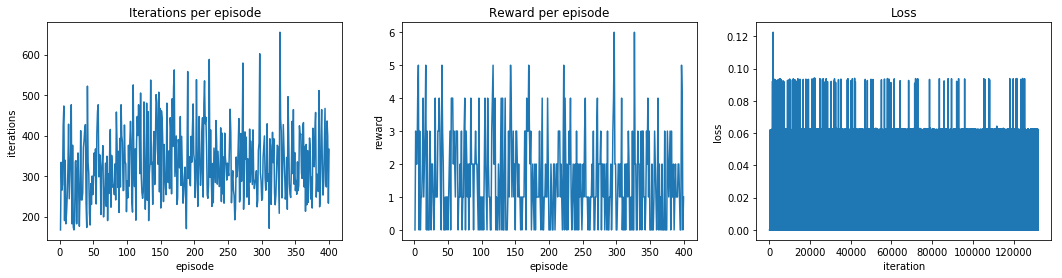

In [15]:
episode_range = np.arange(len(iters_per_episode)) + 1
iter_range = np.arange(len(loss_per_iter)) + 1

plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.title('Iterations per episode')
plt.plot(episode_range, iters_per_episode)
plt.ylabel('iterations')
plt.xlabel('episode')

plt.subplot(1, 3, 2)
plt.title('Reward per episode')
plt.plot(episode_range, reward_per_episode)
plt.ylabel('reward')
plt.xlabel('episode')

plt.subplot(1, 3, 3)
plt.title('Loss')
plt.plot(iter_range, loss_per_iter)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()